In [1]:
#!pip install yfinance
#!pip install pandas-ta

In [2]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

import yfinance as yf



In [3]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# GET THE TRADING DATA

In [4]:
#SPX500 data

df_analisys = yf.download('^GSPC',period="1000d", interval="1d")
df_analisys = df_analisys.reset_index()

print(df_analisys.shape)
df_analisys

[*********************100%***********************]  1 of 1 completed
(1000, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-15,2754.270020,2763.030029,2741.469971,2747.330078,2747.330078,3500330000
1,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000
2,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000
3,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000
4,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000
...,...,...,...,...,...,...,...
995,2022-02-25,4298.379883,4385.339844,4286.830078,4384.649902,4384.649902,3941780000
996,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000
997,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000
998,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000


In [5]:
df_analisys.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys.to_pickle(DIR_OUTPUTS + 'df_spx500_daily_raw' + '.pkl')
print(df_analisys.shape)

(1000, 7)


# Candles computations

In [7]:
#Fixes the trading date
df_analisys['Date'] = df_analisys['Date'].dt.tz_localize(None)
df_analisys['Date']

0     2018-03-15
1     2018-03-16
2     2018-03-19
3     2018-03-20
4     2018-03-21
         ...    
995   2022-02-25
996   2022-02-28
997   2022-03-01
998   2022-03-02
999   2022-03-03
Name: Date, Length: 1000, dtype: datetime64[ns]

In [8]:
df_analisys['date'] = df_analisys['Date']
df_analisys['date']

0     2018-03-15
1     2018-03-16
2     2018-03-19
3     2018-03-20
4     2018-03-21
         ...    
995   2022-02-25
996   2022-02-28
997   2022-03-01
998   2022-03-02
999   2022-03-03
Name: date, Length: 1000, dtype: datetime64[ns]

In [9]:
#Computes body sizes

df_analisys['body_size'] = df_analisys['Close'] - df_analisys['Open']
df_analisys['abs_body_size'] = abs(df_analisys['body_size'])
df_analisys['upper_tail_size'] = df_analisys['High'] - df_analisys[['Open','Close']].max(axis=1)
df_analisys['lower_tail_size'] = df_analisys[['Open','Close']].min(axis=1) - df_analisys['Low']

df_analisys[0:50]

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size
0,2018-03-15,2754.270020,2763.030029,2741.469971,2747.330078,2747.330078,3500330000,2018-03-15,-6.939941,6.939941,8.760010,5.860107
1,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000,2018-03-16,1.439941,1.439941,9.840088,0.600098
2,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000,2018-03-19,-28.459961,28.459961,0.000000,18.329834
3,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000,2018-03-20,1.889893,1.889893,7.280029,5.000000
4,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000,2018-03-21,-3.060059,3.060059,24.149902,2.139893
5,2018-03-22,2691.360107,2695.679932,2641.590088,2643.689941,2643.689941,3739800000,2018-03-22,-47.670166,47.670166,4.319824,2.099854
6,2018-03-23,2646.709961,2657.669922,2585.889893,2588.260010,2588.260010,3815080000,2018-03-23,-58.449951,58.449951,10.959961,2.370117
7,2018-03-26,2619.350098,2661.360107,2601.810059,2658.550049,2658.550049,3511100000,2018-03-26,39.199951,39.199951,2.810059,17.540039
8,2018-03-27,2667.570068,2674.780029,2596.120117,2612.620117,2612.620117,3706350000,2018-03-27,-54.949951,54.949951,7.209961,16.500000
9,2018-03-28,2611.300049,2632.649902,2593.060059,2605.000000,2605.000000,3864500000,2018-03-28,-6.300049,6.300049,21.349854,11.939941


In [10]:
#Computes candles color
df_analisys['body_disposal']=None
df_analisys.loc[df_analisys['body_size']>0,'body_disposal'] = 1
df_analisys.loc[df_analisys['body_size']<0,'body_disposal'] = 0

print(df_analisys['body_disposal'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))




   index  body_disposal
1      0            454
0      1            546


# Target signal

In [11]:
#Computes Target signal

nro_rows = len(df_analisys)
for i in range(0,nro_rows):
    
    profit_threshold = 60
    
    try:
        #Searches for the after indexes where the profit threshold is fullfilled 
        s_threshold = ((df_analisys['Close'][i] - df_analisys['Close'].iloc[i+1:]).abs() > profit_threshold)
        idxs = s_threshold[s_threshold].index
        
        try:
            target_idx = [min(idxs)]
        except:
            target_idx = []
        
        df_data = df_analisys.iloc[target_idx]

        Datetime = df_analisys['date'][i]

        keepcols = ['date','Close']
        df_data = df_data[keepcols]

        dic_rencols = {
            'date':'target_date',
            'Close': 'target_close',
        }

        df_data = df_data.rename(columns=dic_rencols)
        df_data['date'] = Datetime

        if i == 0:
            df_target =df_data.copy()
        else:
            df_target =df_target.append(df_data).copy()
            
    except:
        pass
        
df_target = df_target.reset_index(drop=True)
df_target

,target_date,target_close,date
0,2018-03-22,2643.689941,2018-03-15
1,2018-03-22,2643.689941,2018-03-16
2,2018-03-22,2643.689941,2018-03-19
3,2018-03-22,2643.689941,2018-03-20
4,2018-03-22,2643.689941,2018-03-21
...,...,...,...
993,2022-02-24,4288.700195,2022-02-23
994,2022-02-25,4384.649902,2022-02-24
995,2022-03-01,4306.259766,2022-02-25
996,2022-03-01,4306.259766,2022-02-28


In [12]:
df_analisys_01 = pd.merge(df_analisys,
                         df_target,
                         on = ['date'],
                         how = 'left').copy()

#Computes the target difference in closure prices
df_analisys_01['target_difference'] =  round( df_analisys_01['target_close'] - df_analisys_01['Close'] )

print(df_analisys.shape)
print(df_analisys_01.shape)

print(df_analisys_01['target_difference'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))

df_analisys_01

(1000, 13)
(1000, 16)
     index  target_difference
150 -325.0                  1
145 -277.0                  1
148 -261.0                  1
161 -230.0                  1
146 -226.0                  1
..     ...                ...
153  183.0                  1
155  193.0                  1
151  210.0                  1
149  230.0                  1
108    NaN                  2

[163 rows x 2 columns]


,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference
0,2018-03-15,2754.270020,2763.030029,2741.469971,2747.330078,2747.330078,3500330000,2018-03-15,-6.939941,6.939941,8.760010,5.860107,0,2018-03-22,2643.689941,-104.0
1,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000,2018-03-16,1.439941,1.439941,9.840088,0.600098,1,2018-03-22,2643.689941,-108.0
2,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000,2018-03-19,-28.459961,28.459961,0.000000,18.329834,0,2018-03-22,2643.689941,-69.0
3,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000,2018-03-20,1.889893,1.889893,7.280029,5.000000,1,2018-03-22,2643.689941,-73.0
4,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000,2018-03-21,-3.060059,3.060059,24.149902,2.139893,0,2018-03-22,2643.689941,-68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-25,4298.379883,4385.339844,4286.830078,4384.649902,4384.649902,3941780000,2022-02-25,86.270020,86.270020,0.689941,11.549805,1,2022-03-01,4306.259766,-78.0
996,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000,2022-02-28,19.770020,19.770020,14.899902,39.049805,1,2022-03-01,4306.259766,-68.0
997,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000,2022-03-01,-56.880371,56.880371,15.310059,26.719727,0,2022-03-02,4386.540039,80.0
998,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000,2022-03-02,63.979980,63.979980,14.939941,0.000000,1,NaT,NaN,NaN


In [13]:
df_varbins = df_analisys_01[['target_difference']]
df_varbins['target_bins'] = pd.qcut(df_varbins['target_difference'], 20, duplicates='drop')
df_varbins['target_bins'] = df_varbins['target_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_bins'].astype(str)

print(df_varbins['target_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                    index  target_bins
20                 00-nan            2
9   01-(-325.001, -126.3]           50
4     02-(-126.3, -109.0]           52
10     03-(-109.0, -96.0]           50
12      04-(-96.0, -88.0]           49
2       05-(-88.0, -79.0]           56
16      06-(-79.0, -72.0]           44
11      07-(-72.0, -65.0]           49
0        08-(-65.0, 60.0]           74
17        09-(60.0, 61.0]           40
1         10-(61.0, 63.0]           61
18        11-(63.0, 64.0]           40
3         12-(64.0, 66.0]           52
6         13-(66.0, 68.0]           51
15        14-(68.0, 70.0]           46
19        15-(70.0, 72.0]           36
13        16-(72.0, 75.0]           49
7         17-(75.0, 79.0]           50
5         18-(79.0, 84.0]           51
8         19-(84.0, 96.0]           50
14       20-(96.0, 230.0]           48


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#Computes the target difference in transcurred time
df_analisys_01['target_date_diff'] =  df_analisys_01['target_date'] - df_analisys_01['date']
df_analisys_01['target_date_diff'] = df_analisys_01['target_date_diff'] / np.timedelta64(1,'m')

df_analisys_01

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference,target_date_diff
0,2018-03-15,2754.270020,2763.030029,2741.469971,2747.330078,2747.330078,3500330000,2018-03-15,-6.939941,6.939941,8.760010,5.860107,0,2018-03-22,2643.689941,-104.0,10080.0
1,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000,2018-03-16,1.439941,1.439941,9.840088,0.600098,1,2018-03-22,2643.689941,-108.0,8640.0
2,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000,2018-03-19,-28.459961,28.459961,0.000000,18.329834,0,2018-03-22,2643.689941,-69.0,4320.0
3,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000,2018-03-20,1.889893,1.889893,7.280029,5.000000,1,2018-03-22,2643.689941,-73.0,2880.0
4,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000,2018-03-21,-3.060059,3.060059,24.149902,2.139893,0,2018-03-22,2643.689941,-68.0,1440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-25,4298.379883,4385.339844,4286.830078,4384.649902,4384.649902,3941780000,2022-02-25,86.270020,86.270020,0.689941,11.549805,1,2022-03-01,4306.259766,-78.0,5760.0
996,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000,2022-02-28,19.770020,19.770020,14.899902,39.049805,1,2022-03-01,4306.259766,-68.0,1440.0
997,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000,2022-03-01,-56.880371,56.880371,15.310059,26.719727,0,2022-03-02,4386.540039,80.0,1440.0
998,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000,2022-03-02,63.979980,63.979980,14.939941,0.000000,1,NaT,NaN,NaN,NaN


In [15]:
df_varbins = df_analisys_01[['target_date_diff']]
df_varbins['target_date_bins'] = pd.qcut(df_varbins['target_date_diff'], 20, duplicates='drop')
df_varbins['target_date_bins'] = df_varbins['target_date_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_date_bins'].astype(str)

df_obs = df_varbins['target_date_bins'].value_counts(dropna=False).reset_index().sort_values(['index'])

df_obs['pp_cases'] = df_obs['target_date_bins'] / sum(df_obs['target_date_bins'])

df_obs['app_cases'] = df_obs['pp_cases'].cumsum()

df_obs

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,target_date_bins,pp_cases,app_cases
17,00-nan,2,0.002,0.002
0,"01-(1439.999, 2880.0]",145,0.145,0.147
8,"02-(2880.0, 4320.0]",55,0.055,0.202
6,"04-(4896.0, 5760.0]",58,0.058,0.260
3,"05-(5760.0, 7200.0]",63,0.063,0.323
2,"06-(7200.0, 8640.0]",66,0.066,0.389
1,"07-(8640.0, 10080.0]",76,0.076,0.465
7,"08-(10080.0, 11520.0]",57,0.057,0.522
15,"09-(11520.0, 12960.0]",40,0.040,0.562
4,"10-(12960.0, 15840.0]",61,0.061,0.623


In [16]:
# Computes high time to produce additional categories fo the target

df_varbins = df_varbins.sort_values(['target_date_diff'])
df_varbins = df_varbins[df_varbins.notna().all(axis=1)]
size = round(len(df_varbins)*(0.5))

high_time = df_varbins.iloc[size,:]['target_date_diff']
high_time

11520.0

In [17]:
mean_time = df_varbins['target_date_diff'].mode()
print('Mean awaiting time to profit: ', mean_time)

Mean awaiting time to profit:  0    10080.0
dtype: float64


In [18]:
#computes the target order movement
df_analisys_01['target_order'] = 'NULL'

df_analisys_01.loc[df_analisys_01['target_difference'] < 0, 'target_order'] = 'SELL'

df_analisys_01.loc[(df_analisys_01['target_difference'] < 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'SELL2'


df_analisys_01.loc[df_analisys_01['target_difference'] > 0, 'target_order'] = 'BUY'

df_analisys_01.loc[(df_analisys_01['target_difference'] > 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'BUY2'


df_analisys_01.loc[abs(df_analisys_01['target_difference']) < profit_threshold, 'target_order'] = 'NULL'

df_analisys_01['target_order_bin'] = 0
df_analisys_01.loc[df_analisys_01['target_order'] == 'BUY', 'target_order_bin'] = 1

print(df_analisys_01['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))
print(df_analisys_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
1    BUY           293
0   BUY2           310
4   NULL             2
2   SELL           227
3  SELL2           168
   index  target_order_bin
0      0               707
1      1               293


# MACD and EMA indicators

In [19]:
# # Calculate MACD values using the pandas_ta library
df_macd = df_analisys_01.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
df_macd


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
995,-64.101048,-9.540551,-54.560497
996,-59.780003,-4.175605,-55.604399
997,-61.112304,-4.406324,-56.705980
998,-55.055569,1.320329,-56.375897


In [20]:
ewm50 = df_analisys_01['Close'].ewm(span=50, adjust=False, min_periods=50).mean()
ewm200 = df_analisys_01['Close'].ewm(span=200, adjust=False, min_periods=200).mean()

df_macd['ewm50'] = ewm50
df_macd['ewm200'] = ewm200

#df_analisys_01['ewm50'] = ewm50
#df_analisys_01['ewm200'] = ewm200

df_analisys_01['diff_ewm50'] = df_analisys_01['Close'] - ewm50
df_analisys_01['diff_ewm200'] = df_analisys_01['Close'] - ewm200

df_analisys_01

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2018-03-15,2754.270020,2763.030029,2741.469971,2747.330078,2747.330078,3500330000,2018-03-15,-6.939941,6.939941,...,2643.689941,-104.0,10080.0,SELL,0,NaN,NaN,NaN,NaN,NaN
1,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000,2018-03-16,1.439941,1.439941,...,2643.689941,-108.0,8640.0,SELL,0,NaN,NaN,NaN,NaN,NaN
2,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000,2018-03-19,-28.459961,28.459961,...,2643.689941,-69.0,4320.0,SELL,0,NaN,NaN,NaN,NaN,NaN
3,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000,2018-03-20,1.889893,1.889893,...,2643.689941,-73.0,2880.0,SELL,0,NaN,NaN,NaN,NaN,NaN
4,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000,2018-03-21,-3.060059,3.060059,...,2643.689941,-68.0,1440.0,SELL,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-25,4298.379883,4385.339844,4286.830078,4384.649902,4384.649902,3941780000,2022-02-25,86.270020,86.270020,...,4306.259766,-78.0,5760.0,SELL,0,-64.101048,-9.540551,-54.560497,-117.956428,-21.147712
996,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000,2022-02-28,19.770020,19.770020,...,4306.259766,-68.0,1440.0,SELL,0,-59.780003,-4.175605,-55.604399,-123.620648,-31.540681
997,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000,2022-03-01,-56.880371,56.880371,...,4386.540039,80.0,1440.0,BUY,1,-61.112304,-4.406324,-56.705980,-183.798830,-98.233584
998,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000,2022-03-02,63.979980,63.979980,...,NaN,NaN,NaN,NULL,0,-55.055569,1.320329,-56.375897,-99.459006,-17.774671


In [21]:
#Keeps only the data where MACD is available

df_analisys_02 = df_analisys_01[df_macd.notna().all(axis=1)]

#df_macd[df_macd.notna().all(axis=1)]

print(df_analisys_01.shape)
print(df_analisys_02.shape)

df_analisys_02

(1000, 24)
(801, 24)


,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
199,2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3702620000,2018-12-28,-13.030029,13.030029,...,2549.689941,64.0,14400.0,BUY2,0,-70.522259,-9.532257,-60.990002,-164.784956,-253.851285
200,2018-12-31,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3442870000,2018-12-31,7.910156,7.910156,...,2574.409912,68.0,11520.0,BUY,1,-65.634813,-3.715849,-61.918965,-138.040540,-230.425345
201,2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000,2019-01-02,33.070068,33.070068,...,2447.889893,-62.0,1440.0,SELL,0,-60.803973,0.891994,-61.695966,-129.571957,-224.984265
202,2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3822860000,2019-01-03,-44.030029,44.030029,...,2531.939941,84.0,1440.0,BUY,1,-61.283251,0.330172,-61.613423,-184.193973,-284.267443
203,2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4213410000,2019-01-04,57.609863,57.609863,...,2596.639893,65.0,8640.0,BUY,1,-54.255522,5.886321,-60.141843,-96.216711,-198.225181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-25,4298.379883,4385.339844,4286.830078,4384.649902,4384.649902,3941780000,2022-02-25,86.270020,86.270020,...,4306.259766,-78.0,5760.0,SELL,0,-64.101048,-9.540551,-54.560497,-117.956428,-21.147712
996,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000,2022-02-28,19.770020,19.770020,...,4306.259766,-68.0,1440.0,SELL,0,-59.780003,-4.175605,-55.604399,-123.620648,-31.540681
997,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000,2022-03-01,-56.880371,56.880371,...,4386.540039,80.0,1440.0,BUY,1,-61.112304,-4.406324,-56.705980,-183.798830,-98.233584
998,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000,2022-03-02,63.979980,63.979980,...,NaN,NaN,NaN,NULL,0,-55.055569,1.320329,-56.375897,-99.459006,-17.774671


# Data preparation

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Close price info

In [23]:
# Prepares previos close info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['Close']]
        Datetime = df_analisys_02.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Close']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['date'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_close_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 130

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['Close']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['Close']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss160_close_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    # Keep anly a few of this standarization
    
    try:
        ls_keepcols = ['ss160_close_' + str(x) for x in range(30,0,-1) ]
        df_ssdata2 = df_ssdata2[ls_keepcols]
    except:
        pass
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_close_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_close_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_close_info['date'] = Datetime
    
    if i == 0:
        df_close_info_01 = df_close_info.copy()
    else:
        df_close_info_01 = df_close_info_01.append(df_close_info,sort=False).copy()
        
df_close_info_01 = df_close_info_01.reset_index(drop=True)
df_close_info_01

,ss80_close_80,ss80_close_79,ss80_close_78,ss80_close_77,ss80_close_76,ss80_close_75,ss80_close_74,ss80_close_73,ss80_close_72,ss80_close_71,...,ss160_close_5,ss160_close_4,ss160_close_3,ss160_close_2,ss160_close_1,slope_close_0,slope_close_1,slope_close_2,slope_close_3,date
0,0.837288,0.724332,0.459695,0.477274,0.707853,0.707508,0.831793,0.747815,0.856788,0.811606,...,-1.122281,-1.199440,-1.687033,-1.108664,-1.367230,0.152403,-0.038041,0.095510,-0.051583,2022-03-03
1,0.788255,0.817237,0.702921,0.435098,0.452888,0.686243,0.685894,0.811675,0.726686,0.836971,...,-1.831583,-1.135985,-1.213628,-1.704283,-1.122282,0.043780,0.081507,0.067214,-0.062457,2022-03-02
2,0.647424,0.769973,0.799228,0.683831,0.413475,0.431434,0.666996,0.666643,0.793614,0.707822,...,-2.306162,-1.845932,-1.147217,-1.225208,-1.718062,-0.274951,0.173100,-0.007498,-0.100218,2022-03-01
3,0.491176,0.631190,0.756688,0.786648,0.668473,0.391610,0.410001,0.651233,0.650872,0.780898,...,-1.758095,-2.341588,-1.876322,-1.169962,-1.248806,0.306171,0.213725,-0.080844,-0.133556,2022-02-28
4,0.257113,0.475384,0.617568,0.745013,0.775437,0.655430,0.374274,0.392950,0.637922,0.637555,...,-1.446830,-1.773250,-2.359778,-1.892092,-1.182057,0.580512,0.040488,-0.177592,-0.158975,2022-02-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.378893,0.365151,0.477230,-1.712951,1.249463,0.386116,0.117861,NaN,NaN,2019-01-04
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.076204,0.776073,0.904457,-1.604326,-1.190200,NaN,NaN,NaN,2019-01-03
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.403920,0.554459,0.849461,1.126690,NaN,NaN,NaN,2019-01-02
799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2018-12-31


In [24]:
df_close_info_01[[
    'ss80_close_1',
    'ss80_close_2',
    'ss80_close_3',
    'ss80_close_4',
    
    'ss160_close_1',
    'ss160_close_2',
    'ss160_close_3',
    'ss160_close_4',
]]


,ss80_close_1,ss80_close_2,ss80_close_3,ss80_close_4,ss160_close_1,ss160_close_2,ss160_close_3,ss160_close_4
0,-1.573215,-1.326773,-1.878021,-1.413292,-1.367230,-1.108664,-1.687033,-1.199440
1,-1.372878,-1.930763,-1.460439,-1.386013,-1.122282,-1.704283,-1.213628,-1.135985
2,-1.974762,-1.499990,-1.424860,-2.097941,-1.718062,-1.225208,-1.147217,-1.845932
3,-1.567906,-1.490969,-2.180249,-2.634265,-1.248806,-1.169962,-1.876322,-2.341588
4,-1.537498,-2.237467,-2.698523,-2.120310,-1.182057,-1.892092,-2.359778,-1.773250
...,...,...,...,...,...,...,...,...
796,1.249463,-1.712951,0.477230,0.365151,1.249463,-1.712951,0.477230,0.365151
797,-1.604326,0.904457,0.776073,-0.076204,-1.604326,0.904457,0.776073,-0.076204
798,0.849461,0.554459,-1.403920,NaN,0.849461,0.554459,-1.403920,NaN
799,1.000000,-1.000000,NaN,NaN,1.000000,-1.000000,NaN,NaN


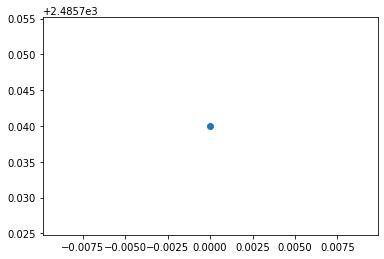

In [25]:
data = X
plt.scatter(range(0,len(data)), data)
plt.show()

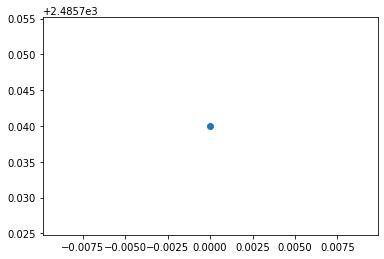

In [26]:
data = X2
plt.scatter(range(0,len(data)), data)
plt.show()

In [27]:
ls_ss160vars = ['ss160_close_' + str(x) for x in range(30,0,-1)]
ls_ss160vars

['ss160_close_30',
 'ss160_close_29',
 'ss160_close_28',
 'ss160_close_27',
 'ss160_close_26',
 'ss160_close_25',
 'ss160_close_24',
 'ss160_close_23',
 'ss160_close_22',
 'ss160_close_21',
 'ss160_close_20',
 'ss160_close_19',
 'ss160_close_18',
 'ss160_close_17',
 'ss160_close_16',
 'ss160_close_15',
 'ss160_close_14',
 'ss160_close_13',
 'ss160_close_12',
 'ss160_close_11',
 'ss160_close_10',
 'ss160_close_9',
 'ss160_close_8',
 'ss160_close_7',
 'ss160_close_6',
 'ss160_close_5',
 'ss160_close_4',
 'ss160_close_3',
 'ss160_close_2',
 'ss160_close_1']

In [28]:
ls_ss80vars = ['ss80_close_' + str(x) for x in range(80,8,-1) ]
ls_ss80vars

['ss80_close_80',
 'ss80_close_79',
 'ss80_close_78',
 'ss80_close_77',
 'ss80_close_76',
 'ss80_close_75',
 'ss80_close_74',
 'ss80_close_73',
 'ss80_close_72',
 'ss80_close_71',
 'ss80_close_70',
 'ss80_close_69',
 'ss80_close_68',
 'ss80_close_67',
 'ss80_close_66',
 'ss80_close_65',
 'ss80_close_64',
 'ss80_close_63',
 'ss80_close_62',
 'ss80_close_61',
 'ss80_close_60',
 'ss80_close_59',
 'ss80_close_58',
 'ss80_close_57',
 'ss80_close_56',
 'ss80_close_55',
 'ss80_close_54',
 'ss80_close_53',
 'ss80_close_52',
 'ss80_close_51',
 'ss80_close_50',
 'ss80_close_49',
 'ss80_close_48',
 'ss80_close_47',
 'ss80_close_46',
 'ss80_close_45',
 'ss80_close_44',
 'ss80_close_43',
 'ss80_close_42',
 'ss80_close_41',
 'ss80_close_40',
 'ss80_close_39',
 'ss80_close_38',
 'ss80_close_37',
 'ss80_close_36',
 'ss80_close_35',
 'ss80_close_34',
 'ss80_close_33',
 'ss80_close_32',
 'ss80_close_31',
 'ss80_close_30',
 'ss80_close_29',
 'ss80_close_28',
 'ss80_close_27',
 'ss80_close_26',
 'ss80_clo

In [29]:
ls_ss80vars2 = ['ss80_close_' + str(x) for x in range(8,0,-1) ]
ls_ss80vars2

['ss80_close_8',
 'ss80_close_7',
 'ss80_close_6',
 'ss80_close_5',
 'ss80_close_4',
 'ss80_close_3',
 'ss80_close_2',
 'ss80_close_1']

In [30]:
ls_slopevars = ['slope_close_' + str(x) for x in range(0,4) ]
ls_slopevars

['slope_close_0', 'slope_close_1', 'slope_close_2', 'slope_close_3']

In [31]:
#Assigns correct format to variable to apply transformations
df_close_info_01[ls_ss80vars2] = df_close_info_01[ls_ss80vars2].astype(float)
df_close_info_01[ls_ss80vars] = df_close_info_01[ls_ss80vars].astype(float)
df_close_info_01[ls_ss160vars] = df_close_info_01[ls_ss160vars].astype(float)
df_close_info_01[ls_slopevars] = df_close_info_01[ls_slopevars].astype(float)

In [32]:
df_close_info_01 = df_close_info_01[df_close_info_01.notna().all(axis=1)]

df_close_info_01[ls_slopevars + ls_ss80vars2 + ls_ss80vars + ls_ss160vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 721
Columns: 114 entries, slope_close_0 to ss160_close_1
dtypes: float64(114)
memory usage: 648.7 KB


In [33]:
#Defines X vector to all process

X = df_close_info_01[ls_ss80vars + ls_ss160vars + ls_slopevars + ls_ss80vars2]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(722, 114)


In [34]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                     ("pca2", pca_pip, ls_ss160vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [35]:
Xtr.shape

(722, 18)

In [36]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_close_c1','ss80_close_c2','ss80_close_c3']
ls_ss160pcavars = ['ss160_close_c1','ss160_close_c2','ss160_close_c3']

df_close_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars + ls_ss160pcavars)
print(df_close_info_tr_01.shape)
df_close_info_tr_01

(722, 18)


,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,ss80_close_4,ss80_close_3,ss80_close_2,ss80_close_1,ss80_close_c1,ss80_close_c2,ss80_close_c3,ss160_close_c1,ss160_close_c2,ss160_close_c3
0,0.152403,-0.038041,0.095510,-0.051583,-1.888321,-2.432562,-1.998595,-1.339752,-1.413292,-1.878021,-1.326773,-1.573215,8.882371,3.674357,-1.096147,9.488701,0.180995,2.379431
1,0.043780,0.081507,0.067214,-0.062457,-1.634654,-1.941186,-2.491979,-2.052788,-1.386013,-1.460439,-1.930763,-1.372878,8.707177,3.647583,-1.442141,9.350472,0.183713,2.442310
2,-0.274951,0.173100,-0.007498,-0.100218,-1.455657,-1.675853,-1.985284,-2.541287,-2.097941,-1.424860,-1.499990,-1.974762,8.523181,3.623169,-1.805549,9.222370,0.303515,2.412566
3,0.306171,0.213725,-0.080844,-0.133556,-0.841844,-1.522506,-1.748002,-2.064881,-2.634265,-2.180249,-1.490969,-1.567906,8.442359,3.713787,-2.252370,8.950705,0.407166,1.971647
4,0.580512,0.040488,-0.177592,-0.158975,-0.907050,-0.878308,-1.569525,-1.798517,-2.120310,-2.698523,-2.237467,-1.537498,8.283440,3.766049,-2.649805,8.725547,0.620442,1.600614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,0.027919,0.050693,0.053447,0.041246,1.219844,1.247433,1.488698,1.428359,1.418223,1.546879,1.576440,1.602716,-2.843610,0.818433,1.605330,-0.976401,-1.037182,0.192970
718,0.076041,0.028261,0.055891,0.039032,1.187384,1.228697,1.255216,1.487128,1.429128,1.419385,1.543053,1.571468,-2.807127,0.996992,1.630397,-0.932581,-1.026537,0.118707
719,0.055995,0.049930,0.047577,0.038838,1.273818,1.215206,1.255818,1.281887,1.509858,1.452844,1.443267,1.564834,-2.829227,1.120443,1.580793,-0.885100,-1.019701,0.056802
720,-0.032779,0.053738,0.036135,0.031589,1.288382,1.301302,1.243599,1.283581,1.309245,1.533679,1.477549,1.468120,-2.854852,1.233271,1.511395,-0.831372,-1.025054,0.018324


In [37]:
# Concat the Datetime to the transformed data

df_close_info_tr_01 = pd.concat([df_close_info_01['date'],df_close_info_tr_01],axis=1)
df_close_info_tr_01

,date,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,ss80_close_4,ss80_close_3,ss80_close_2,ss80_close_1,ss80_close_c1,ss80_close_c2,ss80_close_c3,ss160_close_c1,ss160_close_c2,ss160_close_c3
0,2022-03-03,0.152403,-0.038041,0.095510,-0.051583,-1.888321,-2.432562,-1.998595,-1.339752,-1.413292,-1.878021,-1.326773,-1.573215,8.882371,3.674357,-1.096147,9.488701,0.180995,2.379431
1,2022-03-02,0.043780,0.081507,0.067214,-0.062457,-1.634654,-1.941186,-2.491979,-2.052788,-1.386013,-1.460439,-1.930763,-1.372878,8.707177,3.647583,-1.442141,9.350472,0.183713,2.442310
2,2022-03-01,-0.274951,0.173100,-0.007498,-0.100218,-1.455657,-1.675853,-1.985284,-2.541287,-2.097941,-1.424860,-1.499990,-1.974762,8.523181,3.623169,-1.805549,9.222370,0.303515,2.412566
3,2022-02-28,0.306171,0.213725,-0.080844,-0.133556,-0.841844,-1.522506,-1.748002,-2.064881,-2.634265,-2.180249,-1.490969,-1.567906,8.442359,3.713787,-2.252370,8.950705,0.407166,1.971647
4,2022-02-25,0.580512,0.040488,-0.177592,-0.158975,-0.907050,-0.878308,-1.569525,-1.798517,-2.120310,-2.698523,-2.237467,-1.537498,8.283440,3.766049,-2.649805,8.725547,0.620442,1.600614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2019-04-30,0.027919,0.050693,0.053447,0.041246,1.219844,1.247433,1.488698,1.428359,1.418223,1.546879,1.576440,1.602716,-2.843610,0.818433,1.605330,-0.976401,-1.037182,0.192970
718,2019-04-29,0.076041,0.028261,0.055891,0.039032,1.187384,1.228697,1.255216,1.487128,1.429128,1.419385,1.543053,1.571468,-2.807127,0.996992,1.630397,-0.932581,-1.026537,0.118707
719,2019-04-26,0.055995,0.049930,0.047577,0.038838,1.273818,1.215206,1.255818,1.281887,1.509858,1.452844,1.443267,1.564834,-2.829227,1.120443,1.580793,-0.885100,-1.019701,0.056802
720,2019-04-25,-0.032779,0.053738,0.036135,0.031589,1.288382,1.301302,1.243599,1.283581,1.309245,1.533679,1.477549,1.468120,-2.854852,1.233271,1.511395,-0.831372,-1.025054,0.018324


## MACD info

### Histogram

In [38]:
for c in df_analisys_02.columns.tolist():
    print(c)

Date
Open
High
Low
Close
Adj Close
Volume
date
body_size
abs_body_size
upper_tail_size
lower_tail_size
body_disposal
target_date
target_close
target_difference
target_date_diff
target_order
target_order_bin
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
diff_ewm50
diff_ewm200


In [39]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['date'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_macdh_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 130

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['MACDh_12_26_9']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['MACDh_12_26_9']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss160_macdh_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    # Keep anly a few of this standarization
    
    try:
        ls_keepcols = ['ss160_macdh_' + str(x) for x in range(30,0,-1) ]
        df_ssdata2 = df_ssdata2[ls_keepcols]
    except:
        pass
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macdh_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macdh_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_macdh_info['date'] = Datetime
    
    if i == 0:
        df_macdh_info_01 = df_macdh_info.copy()
    else:
        df_macdh_info_01 = df_macdh_info_01.append(df_macdh_info,sort=False).copy()
        
df_macdh_info_01 = df_macdh_info_01.reset_index(drop=True)
df_macdh_info_01

,ss80_macdh_80,ss80_macdh_79,ss80_macdh_78,ss80_macdh_77,ss80_macdh_76,ss80_macdh_75,ss80_macdh_74,ss80_macdh_73,ss80_macdh_72,ss80_macdh_71,...,ss160_macdh_5,ss160_macdh_4,ss160_macdh_3,ss160_macdh_2,ss160_macdh_1,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,date
0,1.411284,1.203091,0.816491,0.524918,0.449434,0.359695,0.348607,0.249038,0.227776,0.154589,...,-0.494445,-0.111466,-0.127936,0.280863,0.405336,0.267127,0.219593,0.207155,-0.021234,2022-03-03
1,1.453718,1.384515,1.178660,0.796401,0.508102,0.433465,0.344734,0.333771,0.235320,0.214296,...,-1.068430,-0.492871,-0.109691,-0.126170,0.282844,0.194319,0.303877,0.114374,-0.069371,2022-03-02
2,1.422198,1.424596,1.356194,1.152723,0.774890,0.489929,0.416157,0.328453,0.317617,0.220306,...,-1.129321,-1.068131,-0.492512,-0.109292,-0.125772,0.179428,0.290218,-0.006407,-0.126817,2022-03-01
3,1.371896,1.388288,1.390657,1.323075,1.122040,0.748731,0.467183,0.394293,0.307640,0.296933,...,-0.609166,-1.131097,-1.069906,-0.494274,-0.111045,0.463496,0.157879,-0.115719,-0.167847,2022-02-28
4,1.321299,1.340407,1.356617,1.358960,1.292128,1.093325,0.724161,0.445739,0.373659,0.287967,...,-0.241898,-0.609619,-1.131569,-1.070375,-0.494723,0.304411,-0.092388,-0.203821,-0.188231,2022-02-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.612046,-0.482959,0.411521,0.302459,1.381025,0.484752,0.677156,NaN,NaN,2019-01-04
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.566457,-0.170277,0.935797,0.800937,0.485607,NaN,NaN,NaN,2019-01-03
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.269236,0.094452,1.174785,1.222010,NaN,NaN,NaN,2019-01-02
799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2018-12-31


In [40]:
# Create variable names lists to naming columns

ls_ss160vars = ['ss160_macdh_' + str(x) for x in range(30,0,-1)]
ls_ss160vars

ls_ss80vars = ['ss80_macdh_' + str(x) for x in range(80,9,-1) ]
ls_ss80vars

ls_ss80vars2 = ['ss80_macdh_' + str(x) for x in range(8,0,-1) ]
ls_ss80vars2

ls_slopevars = ['slope_macdh_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macdh_0', 'slope_macdh_1', 'slope_macdh_2', 'slope_macdh_3']

In [41]:
#Assigns correct format to variable to apply transformations
df_macdh_info_01[ls_ss80vars2] = df_macdh_info_01[ls_ss80vars2].astype(float)
df_macdh_info_01[ls_ss80vars] = df_macdh_info_01[ls_ss80vars].astype(float)
df_macdh_info_01[ls_ss160vars] = df_macdh_info_01[ls_ss160vars].astype(float)
df_macdh_info_01[ls_slopevars] = df_macdh_info_01[ls_slopevars].astype(float)

In [42]:
df_macdh_info_01 = df_macdh_info_01[df_macdh_info_01.notna().all(axis=1)]

df_macdh_info_01[ls_slopevars + ls_ss80vars2 + ls_ss80vars + ls_ss160vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 721
Columns: 113 entries, slope_macdh_0 to ss160_macdh_1
dtypes: float64(113)
memory usage: 643.0 KB


In [43]:
#Defines X vector to all process

X = df_macdh_info_01[ls_ss80vars + ls_ss160vars + ls_slopevars + ls_ss80vars2]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(722, 113)


In [44]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                     ("pca2", pca_pip, ls_ss160vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [45]:
Xtr.shape

(722, 18)

In [46]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_macdh_c1','ss80_macdh_c2','ss80_macdh_c3']
ls_ss160pcavars = ['ss160_macdh_c1','ss160_macdh_c2','ss160_macdh_c3']

df_macdh_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars + ls_ss160pcavars)
print(df_macdh_info_tr_01.shape)
df_macdh_info_tr_01

(722, 18)


,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss80_macdh_8,ss80_macdh_7,ss80_macdh_6,ss80_macdh_5,ss80_macdh_4,ss80_macdh_3,ss80_macdh_2,ss80_macdh_1,ss80_macdh_c1,ss80_macdh_c2,ss80_macdh_c3,ss160_macdh_c1,ss160_macdh_c2,ss160_macdh_c3
0,0.267127,0.219593,0.207155,-0.021234,-0.418875,-0.941425,-0.880161,-0.303847,0.079837,0.063336,0.472888,0.597591,3.294201,-1.073257,2.029282,2.625368,-1.834263,4.646427
1,0.194319,0.303877,0.114374,-0.069371,-0.061083,-0.425093,-0.941776,-0.881200,-0.311357,0.068018,0.051703,0.456656,3.146612,-0.215903,2.652171,3.099192,-1.600342,5.341332
2,0.179428,0.290218,-0.006407,-0.126817,0.263586,-0.072665,-0.432460,-0.943160,-0.883285,-0.320041,0.054942,0.038816,2.894157,0.653283,3.215601,3.510358,-1.218862,5.691700
3,0.463496,0.157879,-0.115719,-0.167847,0.598812,0.243550,-0.088675,-0.444162,-0.948746,-0.889589,-0.333089,0.037404,2.561287,1.466289,3.700117,3.889813,-0.670138,5.593167
4,0.304411,-0.092388,-0.203821,-0.188231,0.493329,0.575906,0.224588,-0.103948,-0.455488,-0.954470,-0.895969,-0.345648,2.158291,2.212051,4.097541,4.183790,-0.043459,5.206324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,0.007644,0.010471,0.017947,-0.016036,-0.611734,-0.670794,-0.528689,-0.528140,-0.573169,-0.524739,-0.505843,-0.509450,-3.775685,-2.532021,6.378318,0.427266,1.125372,2.231270
718,0.033657,0.004909,0.010763,-0.022812,-0.530520,-0.611271,-0.670320,-0.528242,-0.527693,-0.572714,-0.524292,-0.505400,-3.299996,-2.930813,6.432290,0.496382,1.215529,2.223142
719,0.001701,0.024764,-0.008124,-0.031092,-0.401437,-0.531143,-0.611913,-0.670976,-0.528864,-0.528314,-0.573346,-0.524913,-2.771956,-3.284128,6.418936,0.587233,1.306133,2.203044
720,-0.022127,0.021867,-0.026748,-0.042486,-0.340483,-0.392844,-0.521886,-0.602243,-0.661004,-0.519618,-0.519072,-0.563873,-2.134484,-3.641235,6.244523,0.707489,1.401907,2.177232


In [47]:
# Concat the Datetime to the transformed data

df_macdh_info_tr_01 = pd.concat([df_macdh_info_01['date'],df_macdh_info_tr_01],axis=1)
df_macdh_info_tr_01

,date,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss80_macdh_8,ss80_macdh_7,ss80_macdh_6,ss80_macdh_5,ss80_macdh_4,ss80_macdh_3,ss80_macdh_2,ss80_macdh_1,ss80_macdh_c1,ss80_macdh_c2,ss80_macdh_c3,ss160_macdh_c1,ss160_macdh_c2,ss160_macdh_c3
0,2022-03-03,0.267127,0.219593,0.207155,-0.021234,-0.418875,-0.941425,-0.880161,-0.303847,0.079837,0.063336,0.472888,0.597591,3.294201,-1.073257,2.029282,2.625368,-1.834263,4.646427
1,2022-03-02,0.194319,0.303877,0.114374,-0.069371,-0.061083,-0.425093,-0.941776,-0.881200,-0.311357,0.068018,0.051703,0.456656,3.146612,-0.215903,2.652171,3.099192,-1.600342,5.341332
2,2022-03-01,0.179428,0.290218,-0.006407,-0.126817,0.263586,-0.072665,-0.432460,-0.943160,-0.883285,-0.320041,0.054942,0.038816,2.894157,0.653283,3.215601,3.510358,-1.218862,5.691700
3,2022-02-28,0.463496,0.157879,-0.115719,-0.167847,0.598812,0.243550,-0.088675,-0.444162,-0.948746,-0.889589,-0.333089,0.037404,2.561287,1.466289,3.700117,3.889813,-0.670138,5.593167
4,2022-02-25,0.304411,-0.092388,-0.203821,-0.188231,0.493329,0.575906,0.224588,-0.103948,-0.455488,-0.954470,-0.895969,-0.345648,2.158291,2.212051,4.097541,4.183790,-0.043459,5.206324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2019-04-30,0.007644,0.010471,0.017947,-0.016036,-0.611734,-0.670794,-0.528689,-0.528140,-0.573169,-0.524739,-0.505843,-0.509450,-3.775685,-2.532021,6.378318,0.427266,1.125372,2.231270
718,2019-04-29,0.033657,0.004909,0.010763,-0.022812,-0.530520,-0.611271,-0.670320,-0.528242,-0.527693,-0.572714,-0.524292,-0.505400,-3.299996,-2.930813,6.432290,0.496382,1.215529,2.223142
719,2019-04-26,0.001701,0.024764,-0.008124,-0.031092,-0.401437,-0.531143,-0.611913,-0.670976,-0.528864,-0.528314,-0.573346,-0.524913,-2.771956,-3.284128,6.418936,0.587233,1.306133,2.203044
720,2019-04-25,-0.022127,0.021867,-0.026748,-0.042486,-0.340483,-0.392844,-0.521886,-0.602243,-0.661004,-0.519618,-0.519072,-0.563873,-2.134484,-3.641235,6.244523,0.707489,1.401907,2.177232


### MACD model info

In [48]:
# Prepares previos MACD model info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACD_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACD_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['date'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_macd_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    
    try:
        ls_keepcols = ['ss80_macd_' + str(x) for x in range(80,0,-1) ]
        df_ssdata = df_ssdata[ls_keepcols]
    except:
        pass
    ###############################################################################################



    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macd_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macd_info = pd.concat([df_ssdata,df_linregcoefs],axis=1,sort=False)
    df_macd_info['date'] = Datetime
    
    if i == 0:
        df_macd_info_01 = df_macd_info.copy()
    else:
        df_macd_info_01 = df_macd_info_01.append(df_macd_info,sort=False).copy()
        
df_macd_info_01 = df_macd_info_01.reset_index(drop=True)
df_macd_info_01

,ss80_macd_80,ss80_macd_79,ss80_macd_78,ss80_macd_77,ss80_macd_76,ss80_macd_75,ss80_macd_74,ss80_macd_73,ss80_macd_72,ss80_macd_71,...,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,date
0,1.607125,1.606480,1.518596,1.437733,1.419419,1.389470,1.383586,1.341744,1.323053,1.282090,...,-1.395616,-1.297605,-1.327825,-1.190443,-1.133518,0.097153,0.063136,0.026608,-0.048647,2022-03-03
1,1.504360,1.563678,1.563037,1.475708,1.395355,1.377157,1.347397,1.341550,1.299973,1.281399,...,-1.547977,-1.420105,-1.322712,-1.352741,-1.216228,0.053242,0.073086,-0.018713,-0.062086,2022-03-02
2,1.379985,1.467408,1.526563,1.525923,1.438835,1.358703,1.340555,1.310876,1.305045,1.263582,...,-1.496908,-1.576548,-1.449027,-1.351901,-1.381848,0.033589,0.045477,-0.066166,-0.075135,2022-03-01
3,1.257484,1.349473,1.437082,1.496363,1.495722,1.408448,1.328146,1.309959,1.280217,1.274374,...,-1.265025,-1.533538,-1.613347,-1.485555,-1.388223,0.112562,-0.019841,-0.101470,-0.078956,2022-02-28
4,1.138580,1.230563,1.322928,1.410894,1.470417,1.469774,1.382143,1.301513,1.283252,1.253389,...,-1.122784,-1.302248,-1.571857,-1.651992,-1.523678,0.024089,-0.115153,-0.122014,-0.072904,2022-02-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.481996,-0.579115,0.313308,0.224769,1.523034,0.604863,0.681394,NaN,NaN,2019-01-04
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.519685,-0.273728,0.957798,0.835615,0.554672,NaN,NaN,NaN,2019-01-03
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.227116,0.004756,1.222360,1.224738,NaN,NaN,NaN,2019-01-02
799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2018-12-31


In [49]:
df_macd_info_01 [[
    'ss80_macd_1',
    'ss80_macd_2',
    'ss80_macd_3',
    'ss80_macd_4',
    'ss80_macd_5',
    'ss80_macd_6',
    'ss80_macd_7',
    'ss80_macd_8',
    'ss80_macd_9',
    'ss80_macd_10',
]]
    

,ss80_macd_1,ss80_macd_2,ss80_macd_3,ss80_macd_4,ss80_macd_5,ss80_macd_6,ss80_macd_7,ss80_macd_8,ss80_macd_9,ss80_macd_10
0,-1.133518,-1.190443,-1.327825,-1.297605,-1.395616,-1.524301,-1.443934,-1.173547,-0.993565,-0.850413
1,-1.216228,-1.352741,-1.322712,-1.420105,-1.547977,-1.468118,-1.199438,-1.020592,-0.878344,-0.755685
2,-1.381848,-1.351901,-1.449027,-1.576548,-1.496908,-1.228965,-1.050610,-0.908753,-0.786431,-0.835829
3,-1.388223,-1.485555,-1.613347,-1.533538,-1.265025,-1.086291,-0.944132,-0.821550,-0.871053,-0.913136
4,-1.523678,-1.651992,-1.571857,-1.302248,-1.122784,-0.980045,-0.856962,-0.906667,-0.948922,-0.830312
...,...,...,...,...,...,...,...,...,...,...
796,1.523034,0.224769,0.313308,-0.579115,-1.481996,NaN,NaN,NaN,NaN,NaN
797,0.835615,0.957798,-0.273728,-1.519685,NaN,NaN,NaN,NaN,NaN,NaN
798,1.222360,0.004756,-1.227116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Create variable names lists to naming columns

ls_ss80vars = ['ss80_macd_' + str(x) for x in range(80,8,-1) ]
ls_ss80vars

ls_ss80vars2 = ['ss80_macd_' + str(x) for x in range(8,0,-1) ]
ls_ss80vars2

ls_slopevars = ['slope_macd_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macd_0', 'slope_macd_1', 'slope_macd_2', 'slope_macd_3']

In [51]:
#Assigns correct format to variable to apply transformations

df_macd_info_01[ls_ss80vars] = df_macd_info_01[ls_ss80vars].astype(float)
df_macd_info_01[ls_ss80vars2] = df_macd_info_01[ls_ss80vars2].astype(float)
df_macd_info_01[ls_slopevars] = df_macd_info_01[ls_slopevars].astype(float)

In [52]:
df_macd_info_01 = df_macd_info_01[df_macd_info_01.notna().all(axis=1)]

df_macd_info_01[ls_slopevars + ls_ss80vars + ls_ss80vars2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 721
Data columns (total 84 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   slope_macd_0  722 non-null    float64
 1   slope_macd_1  722 non-null    float64
 2   slope_macd_2  722 non-null    float64
 3   slope_macd_3  722 non-null    float64
 4   ss80_macd_80  722 non-null    float64
 5   ss80_macd_79  722 non-null    float64
 6   ss80_macd_78  722 non-null    float64
 7   ss80_macd_77  722 non-null    float64
 8   ss80_macd_76  722 non-null    float64
 9   ss80_macd_75  722 non-null    float64
 10  ss80_macd_74  722 non-null    float64
 11  ss80_macd_73  722 non-null    float64
 12  ss80_macd_72  722 non-null    float64
 13  ss80_macd_71  722 non-null    float64
 14  ss80_macd_70  722 non-null    float64
 15  ss80_macd_69  722 non-null    float64
 16  ss80_macd_68  722 non-null    float64
 17  ss80_macd_67  722 non-null    float64
 18  ss80_macd_66  722 non-null    

In [53]:
#Defines X vector to all process

X = df_macd_info_01[ls_ss80vars + ls_ss80vars2 + ls_slopevars]
print(X.shape)


(722, 84)


In [54]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [55]:
Xtr.shape

(722, 15)

In [56]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_macd_c1','ss80_macd_c2','ss80_macd_c3']

df_macd_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars )
print(df_macd_info_tr_01.shape)
df_macd_info_tr_01

(722, 15)


,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,ss80_macd_8,ss80_macd_7,ss80_macd_6,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,ss80_macd_c1,ss80_macd_c2,ss80_macd_c3
0,0.097153,0.063136,0.026608,-0.048647,-1.173547,-1.443934,-1.524301,-1.395616,-1.297605,-1.327825,-1.190443,-1.133518,-5.407540,-1.862547,-4.212765
1,0.053242,0.073086,-0.018713,-0.062086,-1.020592,-1.199438,-1.468118,-1.547977,-1.420105,-1.322712,-1.352741,-1.216228,-5.335026,-1.743050,-4.534190
2,0.033589,0.045477,-0.066166,-0.075135,-0.908753,-1.050610,-1.228965,-1.496908,-1.576548,-1.449027,-1.351901,-1.381848,-5.278546,-1.638117,-4.826513
3,0.112562,-0.019841,-0.101470,-0.078956,-0.821550,-0.944132,-1.086291,-1.265025,-1.533538,-1.613347,-1.485555,-1.388223,-5.241247,-1.549147,-5.088941
4,0.024089,-0.115153,-0.122014,-0.072904,-0.906667,-0.856962,-0.980045,-1.122784,-1.302248,-1.571857,-1.651992,-1.523678,-5.197982,-1.459651,-5.279649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,0.010236,0.009561,0.010789,-0.001290,0.336896,0.304108,0.366056,0.371401,0.353998,0.378848,0.393768,0.399320,3.614115,-5.289221,4.816666
718,0.018000,0.005691,0.005538,-0.002172,0.389763,0.357568,0.327889,0.383965,0.388803,0.373050,0.395544,0.409050,3.964268,-5.256888,4.603448
719,0.003112,0.011485,-0.002106,-0.002865,0.447464,0.408124,0.378399,0.350996,0.402771,0.407238,0.392693,0.413462,4.310188,-5.243932,4.405832
720,-0.004677,0.007873,-0.007148,-0.003851,0.464841,0.462324,0.425812,0.398224,0.372790,0.420844,0.424990,0.411490,4.635489,-5.209564,4.215594


In [57]:
# Concat the Datetime to the transformed data

df_macd_info_tr_01 = pd.concat([df_macd_info_01['date'],df_macd_info_tr_01],axis=1)
df_macd_info_tr_01

,date,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,ss80_macd_8,ss80_macd_7,ss80_macd_6,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,ss80_macd_c1,ss80_macd_c2,ss80_macd_c3
0,2022-03-03,0.097153,0.063136,0.026608,-0.048647,-1.173547,-1.443934,-1.524301,-1.395616,-1.297605,-1.327825,-1.190443,-1.133518,-5.407540,-1.862547,-4.212765
1,2022-03-02,0.053242,0.073086,-0.018713,-0.062086,-1.020592,-1.199438,-1.468118,-1.547977,-1.420105,-1.322712,-1.352741,-1.216228,-5.335026,-1.743050,-4.534190
2,2022-03-01,0.033589,0.045477,-0.066166,-0.075135,-0.908753,-1.050610,-1.228965,-1.496908,-1.576548,-1.449027,-1.351901,-1.381848,-5.278546,-1.638117,-4.826513
3,2022-02-28,0.112562,-0.019841,-0.101470,-0.078956,-0.821550,-0.944132,-1.086291,-1.265025,-1.533538,-1.613347,-1.485555,-1.388223,-5.241247,-1.549147,-5.088941
4,2022-02-25,0.024089,-0.115153,-0.122014,-0.072904,-0.906667,-0.856962,-0.980045,-1.122784,-1.302248,-1.571857,-1.651992,-1.523678,-5.197982,-1.459651,-5.279649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2019-04-30,0.010236,0.009561,0.010789,-0.001290,0.336896,0.304108,0.366056,0.371401,0.353998,0.378848,0.393768,0.399320,3.614115,-5.289221,4.816666
718,2019-04-29,0.018000,0.005691,0.005538,-0.002172,0.389763,0.357568,0.327889,0.383965,0.388803,0.373050,0.395544,0.409050,3.964268,-5.256888,4.603448
719,2019-04-26,0.003112,0.011485,-0.002106,-0.002865,0.447464,0.408124,0.378399,0.350996,0.402771,0.407238,0.392693,0.413462,4.310188,-5.243932,4.405832
720,2019-04-25,-0.004677,0.007873,-0.007148,-0.003851,0.464841,0.462324,0.425812,0.398224,0.372790,0.420844,0.424990,0.411490,4.635489,-5.209564,4.215594


# Attaches target variable to the df with transformations

In [58]:
ls_tgcols = ['date','Close','target_order','target_order_bin','target_close','target_difference','target_date','target_date_diff']


df_transformations_100 = pd.merge(df_close_info_tr_01,
                           df_macdh_info_tr_01,
                           on = ['date'],
                           how='inner'
                         ).copy()

df_transformations_100 = pd.merge(df_transformations_100,
                           df_macd_info_tr_01,
                           on = ['date'],
                           how='inner'
                         ).copy()

df_analisys_100 = pd.merge(df_transformations_100,
                           df_analisys_02[ls_tgcols],
                           on = ['date'],
                           how='inner'
                         ).copy()


df_analisys_100 = df_analisys_100.sort_values(['date']).reset_index(drop=True)

print(df_analisys_100.shape)

print(min(df_model_preds['Datetime']))
print(max(df_model_preds['Datetime']))

df_analisys_100


(722, 59)


,date,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,ss80_close_4,...,ss80_macd_c1,ss80_macd_c2,ss80_macd_c3,Close,target_order,target_order_bin,target_close,target_difference,target_date,target_date_diff
0,2019-04-24,0.082464,0.070360,0.029196,0.027734,1.325292,1.309639,1.322299,1.265753,1.304933,...,4.942129,-5.153815,4.033624,2927.250000,SELL2,0,2811.870117,-115.0,2019-05-13,27360.0
1,2019-04-25,-0.032779,0.053738,0.036135,0.031589,1.288382,1.301302,1.243599,1.283581,1.309245,...,4.635489,-5.209564,4.215594,2926.169922,SELL2,0,2811.870117,-114.0,2019-05-13,25920.0
2,2019-04-26,0.055995,0.049930,0.047577,0.038838,1.273818,1.215206,1.255818,1.281887,1.509858,...,4.310188,-5.243932,4.405832,2939.879883,SELL2,0,2879.419922,-60.0,2019-05-08,17280.0
3,2019-04-29,0.076041,0.028261,0.055891,0.039032,1.187384,1.228697,1.255216,1.487128,1.429128,...,3.964268,-5.256888,4.603448,2943.030029,SELL2,0,2879.419922,-64.0,2019-05-08,12960.0
4,2019-04-30,0.027919,0.050693,0.053447,0.041246,1.219844,1.247433,1.488698,1.428359,1.418223,...,3.614115,-5.289221,4.816666,2945.830078,SELL,0,2884.050049,-62.0,2019-05-07,10080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2022-02-25,0.580512,0.040488,-0.177592,-0.158975,-0.907050,-0.878308,-1.569525,-1.798517,-2.120310,...,-5.197982,-1.459651,-5.279649,4384.649902,SELL,0,4306.259766,-78.0,2022-03-01,5760.0
718,2022-02-28,0.306171,0.213725,-0.080844,-0.133556,-0.841844,-1.522506,-1.748002,-2.064881,-2.634265,...,-5.241247,-1.549147,-5.088941,4373.939941,SELL,0,4306.259766,-68.0,2022-03-01,1440.0
719,2022-03-01,-0.274951,0.173100,-0.007498,-0.100218,-1.455657,-1.675853,-1.985284,-2.541287,-2.097941,...,-5.278546,-1.638117,-4.826513,4306.259766,BUY,1,4386.540039,80.0,2022-03-02,1440.0
720,2022-03-02,0.043780,0.081507,0.067214,-0.062457,-1.634654,-1.941186,-2.491979,-2.052788,-1.386013,...,-5.335026,-1.743050,-4.534190,4386.540039,NULL,0,NaN,NaN,NaT,NaN


In [59]:
print(df_analisys_100['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
0    BUY           246
1   BUY2           181
4   NULL             2
2   SELL           180
3  SELL2           113


In [60]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys_100.to_pickle(DIR_OUTPUTS + 'df_spx500_daily_s1' + '.pkl')
print(df_analisys_100.shape)
print(dt.datetime.now())

(722, 59)
2022-03-03 15:48:20.246926
